In [25]:
import pandas as pd
import requests
from io import StringIO
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import optuna
import pickle

RS = 42

In [2]:
def get_csv_df(csv_name):
    url = f"https://storage.googleapis.com/nba_award_predictor/nba_data/{csv_name}"

    r = requests.get(url)
    r.raise_for_status()

    csv_text = r.content.decode('utf-8')
    df = pd.read_csv(StringIO(csv_text))
    return df

# Data Extraction and Preparation

In [3]:
# Pull csv file with all features
total = get_csv_df("features-overall-weekly.csv")

NameError: name 'get_csv_df' is not defined

In [26]:
total = pd.read_csv("output.csv")

In [28]:
total.columns

Index(['player_id', 'full_name', 'team', 'season', 'week', 'week_start',
       'conference', 'pow_conference', 'games_played_this_week', 'numMinutes',
       'points', 'assists', 'blocks', 'steals', 'reboundsTotal',
       'reboundsDefensive', 'reboundsOffensive', 'fieldGoalsAttempted',
       'fieldGoalsMade', 'threePointersAttempted', 'threePointersMade',
       'freeThrowsAttempted', 'freeThrowsMade', 'turnovers', 'foulsPersonal',
       'plusMinusPoints', 'wins_this_week', 'wins_vs_team_with_all_nba_player',
       'is_win_vs_over_500', 'opponent_has_all_nba', 'avg_opp_score',
       'avg_opp_winrate_prior', 'avg_opp_wins_prior', 'avg_opp_losses_prior',
       'away_games_prior', 'away_losses_prior', 'away_win_streak_prior',
       'away_wins_prior', 'home_games_prior', 'home_losses_prior',
       'home_win_streak_prior', 'home_wins_prior', 'losses_prior',
       'wins_vs_over_500_prior', 'won_player_of_the_week',
       'all_star_this_season', 'mvp_this_season',
       'all_nba_f

In [29]:
# To conduct week by week inference, we will train our model pre-2025-26 season and inference on our 2025-26 weeks
total_pre = total[total['season'] != 2025]
total_inf = total[total['season'] == 2025] # our inference set

Since up to the 2000-01 season, player of the week award was given league wide, not per conference, we will drop data to only include data where awards were given per conference. While the data being dropped could provide insight, we want our model to trained to fit modern standard. Furthermore, we will be training our model by weekly groups (see below). 

In [30]:
# Dropping rows where season is before 2001-02 season
total_pre = total_pre[total_pre['season'] > 2000]

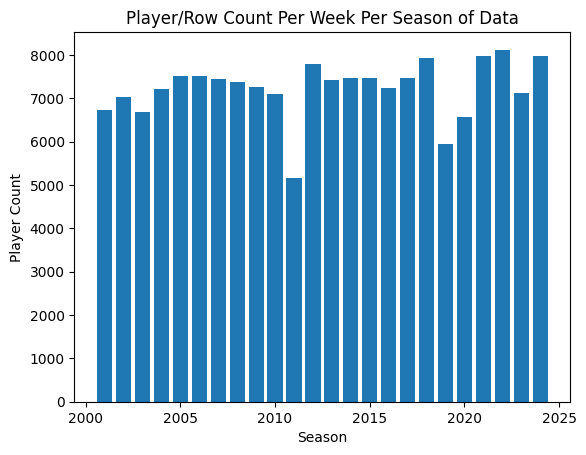

In [31]:
# Visualize season count
season_count = total_pre.groupby('season')['team'].count() # Since we are doing count, we can use arbitrary counter column ('team')
plt.bar(season_count.index, season_count.values)
plt.xlabel("Season")
plt.ylabel("Player Count")
plt.title("Player/Row Count Per Week Per Season of Data")
plt.show()

In [32]:
# Target/y label, 1 if player is winner, 0 otherwise
y = total_pre['won_player_of_the_week']

In [33]:
# full_name, player_id: not features
# pow_player_id, player_of_the_week, won_player_of_week: target labels (y data)
# all_star_this_season, mvp_this_season, all_nba_first_team_this_season, all_nba_second_team_this_season, all_nba_third_team_this_season: "future data", not determined until end of the season
# week_start, pow_conference: redundant, we have season, week, conference
# is_win_vs_over_500, opponent_has_all_nba: these were encoders for game entries, our rows are week entries

X = total_pre.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba'])

In [34]:
# Double check for null values
X.isnull().sum()

team                      0
season                    0
week                      0
conference                0
games_played_this_week    0
                         ..
league_pm_mean            0
league_pm_std             0
z_s_pts                   0
z_s_ast                   0
z_s_pm                    0
Length: 65, dtype: int64

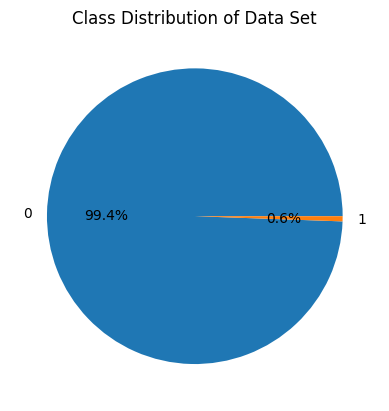

In [35]:
# Visual label/class distribution
tot_y = y.value_counts()
plt.pie(tot_y.values, labels=tot_y.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Data Set")
plt.show()

As we can see, there is extreme imbalance for our prediction label (1 for player won player of the week award for that week, 0 otherwise). This is natural given that player of the week is highly selective, only two (one per conference) are given per week. Given this imbalance, we are highly at risk of our model predicting 0 for all future players. We will take measures to correct this balance as much as possible.

# Light Gradient Boosting Machine (GBM) Model

Our X features contain non-numerical data: 'team' and 'conference'. We do not need to hot encode these categorical features whening using tree-based models. Instead, we cast as category type and indicate our categorical data in the hyper parameters

In [36]:
# Do not need to hot encode category features for tree-based models, instead cast as category type
cat_cols = ['team', 'conference']
for c in cat_cols:
    X[c] = X[c].astype("category")

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173475 entries, 59525 to 232999
Data columns (total 65 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   team                              173475 non-null  category
 1   season                            173475 non-null  int64   
 2   week                              173475 non-null  int64   
 3   conference                        173475 non-null  category
 4   games_played_this_week            173475 non-null  int64   
 5   numMinutes                        173475 non-null  float64 
 6   points                            173475 non-null  float64 
 7   assists                           173475 non-null  float64 
 8   blocks                            173475 non-null  float64 
 9   steals                            173475 non-null  float64 
 10  reboundsTotal                     173475 non-null  float64 
 11  reboundsDefensive                 173475

### 1. Time-based Split

By splitting our data by time, test set = data from 2024-25 season and train set = data pre 2024-25 season, we ensure that all players from a given week are grouped together. This will ensure the integrity of our model as we will be inferencing our model on week by week data. It will also prevent any data leakage where future data is trained to test past data. Lastly, it also maintains the same class distribution as the original data set as each group week remains in tact, where each group has an associated player of the week winner.

In [38]:
train_mask = X['season'] < 2024
X_train, y_train = X[train_mask], y[train_mask] #it is safe to apply the mask to 'y' as we have not altered 'y' ordering

test_mask = X['season'] == 2024
X_test, y_test = X[test_mask], y[test_mask]

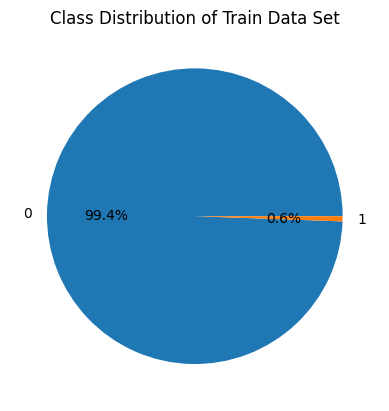

In [39]:
# Plot our split data label distribution
tot_y = y_train.value_counts()
plt.pie(tot_y.values, labels=tot_y.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Train Data Set")
plt.show()

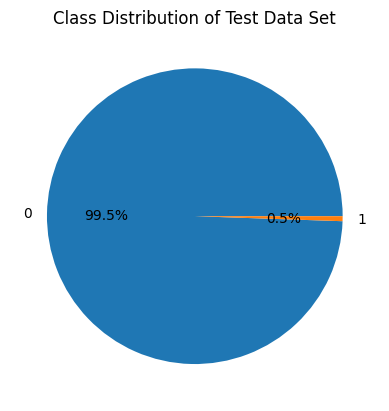

In [40]:
tot_y = y_test.value_counts()
plt.pie(tot_y.values, labels=tot_y.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Test Data Set")
plt.show()

### 2. Utilize Scale Positive Weight

We will use scale_pos_weight for our light gbm model. Using this ratio, we will force our model to pay way more attention to our positive/1-label data rows. This will help address our class imbalance.

In [41]:
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos
scale_pos_weight = num_neg / num_pos
print(f"Imbalance ratio: {scale_pos_weight}")

Imbalance ratio: 177.15285252960172


### 3. Adjust Initialize Hyper Parameters

Since we have small signal, we need more boosting rounds to handle the class imbalance. We will set learning rate low and number of estimators high.

In [42]:
params = {
    "objective" :"binary", # classification: winner vs. non-winner, optimize log loss
    "n_estimators" :2000, # maximum number of boosting rounds i.e. number of trees to build
    "learning_rate":0.01, # how much each tree contributes to final prediction (shrinking rate)
    "scale_pos_weight":scale_pos_weight, # handles our imbalance
    'metric': ['binary_logloss', 'auc'], # log loss: penalizes wrong predictions heavily. AUC: measures ranking quality
    'boosting_type': 'gbdt',
    "max_depth":-1, # maximum depth of each tree. -1 = no limit
    "num_leaves":31, # maximum number of leaves per tree
    'feature_fraction': 0.8, # randomly selects 80% of features per tree
    'bagging_fraction': 0.8, # randomly samples 80% of data per tree
    'bagging_freq': 5, # frequency of bagging. Every 5 iterations bag
    'min_child_samples': 20, # minimum number of samples in a leaf node
    "random_state":RS,
    "n_jobs":-1, # uses maximum number of CPU cores available
    "verbose": -1
}

### Model Selection

We will begin to test which Light GBM model is best for predicting winners. We will be using cross validation to prevent overfitting results swaying our decision. Since our data is temporal, we will be doing a time series cross-validation using seasons. This will prevent future data being trained to predict the past. It always prevent player performances from a given week being split between the train and validation sets.

- Validation sets: 2018-19, 2019-20, 2020-21, 2022-23, 2024-25 seasons
- Training sets: seasons before validation set season

In [47]:
# Perform cross validation on all of X
folds = 5
k = [1, 3, 5, 10]
unique_seasons = sorted(X['season'].unique())

cv_results = []

# Iterate through each fold, using fold number as key for validation season
for fold in range(1, folds + 1):
    val_season = unique_seasons[-fold]
    train_seasons = unique_seasons[:-fold]
    
    val_mask = X['season'] == val_season
    train_mask = X['season'].isin(train_seasons)

    X_val, y_val = X[val_mask], y[val_mask] # Applying mask to 'y' is safe
    X_train, y_train = X[train_mask], y[train_mask]

    print(f"Validation {fold}")
    print(f"Val. Season: {val_season}")
    print(f"Train Seasons: {train_seasons[0]}-{train_seasons[-1]}")
    print(f"Val. Proportion: {len(y_val) / (len(y_val) + len(X_train))}\n")

    model = lgb.LGBMClassifier(**params) # Uses params defined above

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)], # stops splitting if no more gain possible
        categorical_feature=cat_cols, # cat_cols = team, conference
    )

    pred = model.predict_proba(X_val)[:, 1]

    # Predicting if top-k probabilites is a "hit" i.e. 1-label
    df = X_val[['season', 'week', 'conference']].copy()
    df['y_true'] = y_val
    df['y_proba'] = pred

    # Stores k-accuracy
    k_dict = {i: [] for i in k}
    
    # Group data rows by season, week, conference as there is associated winner for each group
    groups = df.groupby(['season', 'week', 'conference'], observed=True)
    ranks = []
    for _, group in groups:
        group_sorted = group.sort_values('y_proba', ascending=False).reset_index(drop=True) # boolean mask for indexes of true winner rows
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1] # sort based on boolean mask
        for i in k:
            top_k = group_sorted.head(i) # Look at top 'k' probabilities
            hit = top_k['y_true'].max() # Returns 1 if winner is in top 'k', else 0
            k_dict[i].append(hit)
        for idx in pos_idx:
            ranks.append(idx + 1) # shift 0 to 1 index
    ranks = np.array(ranks)
    curr = {"Fold": fold, "Max_Prob": pred.max(), "Min_Prob": pred.min(),
            "Num_winners_seen": len(ranks), "Top_rank": ranks.min(), "Lowest_rank": ranks.max(), 
            "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])
    }
    for i, hits in k_dict.items():
        curr[f"Top_{i}_avg_hits"] = np.mean(hits)
    cv_results.append(curr)

Validation 1
Val. Season: 2024
Train Seasons: 2001-2023
Val. Proportion: 0.04594898400345871

Validation 2
Val. Season: 2023
Train Seasons: 2001-2022
Val. Proportion: 0.04295364462490332

Validation 3
Val. Season: 2022
Train Seasons: 2001-2021
Val. Proportion: 0.051251617790965626

Validation 4
Val. Season: 2021
Train Seasons: 2001-2020
Val. Proportion: 0.05308197528563919

Validation 5
Val. Season: 2020
Train Seasons: 2001-2019
Val. Proportion: 0.04621222768798314



In [48]:
top_k_df = pd.DataFrame(cv_results)
top_k_df

,Fold,Max_Prob,Min_Prob,Num_winners_seen,Top_rank,Lowest_rank,Percentiles,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits
0,1,0.194977,0.005019,43,1,17,"[1.0, 1.0, 2.0, 5.0, 9.400000000000013]",0.476190,0.690476,0.833333,0.880952
1,2,0.117014,0.005188,37,1,17,"[1.0, 2.0, 4.0, 7.0, 10.799999999999997]",0.131579,0.394737,0.578947,0.815789
2,3,0.104483,0.005207,43,1,21,"[1.0, 1.0, 3.0, 4.5, 7.6000000000000085]",0.340909,0.681818,0.772727,0.909091
3,4,0.160196,0.005126,41,1,14,"[1.0, 1.0, 2.0, 4.0, 10.0]",0.386364,0.659091,0.750000,0.840909
4,5,0.136397,0.005256,34,1,13,"[1.0, 1.0, 3.0, 5.0, 7.699999999999999]",0.305556,0.555556,0.722222,0.888889


In [49]:
print(f"Across folds:\nAverage Top-1 Hits: {top_k_df['Top_1_avg_hits'].mean()}\nAverage Top-3 Hits: {top_k_df['Top_3_avg_hits'].mean()}\nAverage Top-5 Hits: {top_k_df['Top_5_avg_hits'].mean()}\nAverage Top-10 Hits: {top_k_df['Top_10_avg_hits'].mean()}")

Across folds:
Average Top-1 Hits: 0.32811954127743603
Average Top-3 Hits: 0.5963355358092199
Average Top-5 Hits: 0.7314460393407762
Average Top-10 Hits: 0.8671261487050961


Our results show mediocre accuracy. Across the folds, our model predicts the winner as its top rank around 33% of time and correctly ranks the winner within the top 10 ranks ~87% of the time. We see that our model has ranked a winner as low as 21th. We also want to note that when validating on the second fold, the 2023-24 season, our model performed worse compared to the other folds. This showcases that season-wide changes could affect our model's performance. Lastly, we see that our maximum probability is low when predicting the player of week. However, when comparing it to our lowest probability of a player, there is a significant difference between the probabilites. 

### Changing Our Approach

Since we want to predict on a week by week basis and our winner(s) come from each conference (post 2000-01 season), lets define our groups as per 'season' + 'week' + 'conference' and change our Light GBM objective to "lambdarank" which ranks our probabilites based on the associated groups. We do this because winners are distributed on weekly basis. If we trained our model without grouping, our data isn't independently identically distributed as winners are being compared to all other historical performances. While our winners are based on their performance compared to historical performances, it is also heavily based on the performances of other players for that given week in their conference.

In [30]:
# Group keys
X['key'] = X['season'].astype(str) + '_' + X['week'].astype(str) + '_' + X['conference'].astype(str)
unique_keys = X['key'].unique()

X.head(5)['key']

59525    2001_1_West
59526    2001_1_West
59527    2001_1_East
59528    2001_1_East
59529    2001_1_East
Name: key, dtype: object

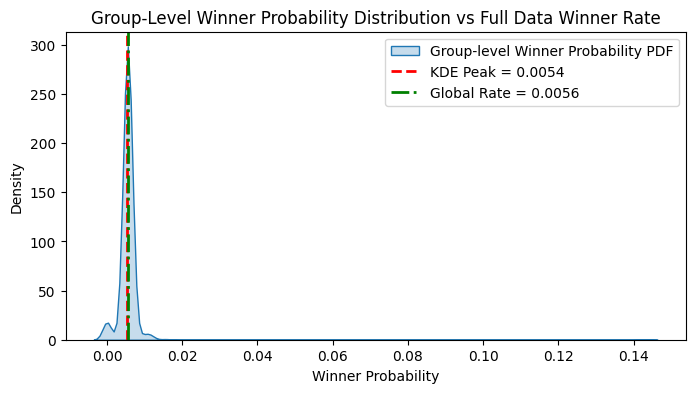

In [31]:
# Graph kernel density estimate of weekly group winners
df_group = pd.DataFrame({
    "key": X["key"],
    "y": y  
})

counts = (
    df_group
    .groupby("key")["y"]
    .value_counts()
    .unstack(fill_value=0)
    .sort_index()
)
prob = counts[1] / (counts[0] + counts[1])

global_rate = y.mean()   # overall % of winners in full dataset

kde = gaussian_kde(prob)
xs = np.linspace(prob.min(), prob.max(), 500)
ys = kde(xs)
x_peak = xs[np.argmax(ys)]  # where density is highest

plt.figure(figsize=(8,4))

# KDE plot
sns.kdeplot(prob, fill=True, label="Group-level Winner Probability PDF")

# Vertical line: KDE peak
plt.axvline(x_peak, color="red", linestyle="--", linewidth=2, 
            label=f"KDE Peak = {x_peak:.4f}")

# Vertical line: Global winner average
plt.axvline(global_rate, color="green", linestyle="-.", linewidth=2, 
            label=f"Global Rate = {global_rate:.4f}")

plt.title("Group-Level Winner Probability Distribution vs Full Data Winner Rate")
plt.xlabel("Winner Probability")
plt.ylabel("Density")
plt.legend()

plt.show()


As we can see here, the kde of winner probabilty per group across our data set is very low. This is expected as there is only 1 winner per group. What changes per group is the number of total players in each group. Furthermore, we can see that our "global" rate (i.e. in our full data set) is approximately the same as our kde peak. This follows suit as the probability per winner per group should be approxiamtely the same as the distribution of winners in our full data set. This finding matches our pie chart above: ~0.6%.

In [32]:
rank_params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',  # Normalized Discounted Cumulative Gain
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'min_child_samples': 20,
            'verbose': -1,
            'random_state': RS,
            'n_jobs': -1,
        } # lambdarank does not utilize scale_pos_weight because it optimizes within groups

In [ ]:
# Perform cross validation on all of X
folds = 5
k = [1, 3, 5, 10]
unique_seasons = sorted(X['season'].unique())

cv_results = []

# Iterate through each fold, using fold number as key for validation season
for fold in range(1, folds + 1):
    val_season = unique_seasons[-fold]
    train_seasons = unique_seasons[:-fold]
    
    val_mask = X['season'] == val_season
    train_mask = X['season'].isin(train_seasons)

    X_val, y_val = X[val_mask], y[val_mask] # Applying mask to 'y' is safe
    X_train, y_train = X[train_mask], y[train_mask]

    # Obtain group sizes/starting index by group key
    X_train = X_train.sort_values(by='key')
    y_train = y_train.loc[X_train.index]

    X_val = X_val.sort_values(by='key')
    y_val = y_val.loc[X_val.index]

    tr_group_sizes = X_train.groupby('key').size().to_numpy()
    val_group_sizes = X_val.groupby('key').size().to_numpy()

    # Drop key feature before training and validation
    X_train = X_train.drop(columns=['key'])
    X_val = X_val.drop(columns=['key'])

    print(f"Validation {fold}")
    print(f"Val. Season: {val_season}")
    print(f"Train Seasons: {train_seasons[0]}-{train_seasons[-1]}")
    print(f"Val. Proportion: {len(y_val) / (len(y_val) + len(X_train))}\n")

    model = lgb.LGBMRanker(**rank_params) # Uses params defined above

    model.fit(
        X_train,
        y_train,
        group=tr_group_sizes, # groups based on sizing key
        eval_set=[(X_val, y_val)],
        eval_group=[val_group_sizes], # groups based on sizing key
        eval_at=[1, 3, 5, 10],  # Evaluate NDCG at these positions
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)], # stops splitting if no more gain possible
        categorical_feature=cat_cols, # cat_cols = team, conference
    )

    pred = model.predict(X_val)

    # Predicting if top-k probabilites is a "hit" i.e. 1-label
    df = X_val[['season', 'week', 'conference']].copy()#.reset_index(drop=True)
    df['y_true'] = y_val#.reset_index(drop=True)
    df['score'] = pred

    # Stores k-accuracy
    k_dict = {i: [] for i in k}
    
    # Group data rows by season, week, conference as there is associated winner for each group
    groups = df.groupby(['season', 'week', 'conference'], observed=True)
    ranks = []
    for _, group in groups:
        group_sorted = group.sort_values('score', ascending=False).reset_index(drop=True) # boolean mask for indexes of true winner rows
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1] # sort based on boolean mask
        for i in k:
            top_k = group_sorted.head(i) # Look at top 'k' probabilities
            hit = top_k['y_true'].max() # Returns 1 if winner is in top 'k', else 0
            k_dict[i].append(hit)
        for idx in pos_idx:
            ranks.append(idx + 1) # shift 0 to 1 index
    ranks = np.array(ranks)
    curr = {"Fold": fold, "Top_rank": ranks.min(), "Lowest_rank": ranks.max(), 
            "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])
    }
    for i, hits in k_dict.items():
        curr[f"Top_{i}_avg_hits"] = np.mean(hits)
    cv_results.append(curr)

#X=X.drop(columns=['key'])

Validation 1
Val. Season: 2024
Train Seasons: 2001-2023
Val. Proportion: 0.04594898400345871

Validation 2
Val. Season: 2023
Train Seasons: 2001-2022
Val. Proportion: 0.04295364462490332

Validation 3
Val. Season: 2022
Train Seasons: 2001-2021
Val. Proportion: 0.051251617790965626

Validation 4
Val. Season: 2021
Train Seasons: 2001-2020
Val. Proportion: 0.05308197528563919

Validation 5
Val. Season: 2020
Train Seasons: 2001-2019
Val. Proportion: 0.04621222768798314



In [34]:
rank_k_df = pd.DataFrame(cv_results)
rank_k_df

,Fold,Top_rank,Lowest_rank,Percentiles,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits
0,1,1,15,"[1.0, 1.0, 2.0, 6.0, 7.800000000000004]",0.500000,0.666667,0.714286,0.928571
1,2,1,28,"[1.0, 1.0, 2.0, 3.0, 8.399999999999999]",0.473684,0.736842,0.815789,0.921053
2,3,1,15,"[1.0, 1.0, 1.0, 3.0, 5.0]",0.522727,0.727273,0.909091,0.954545
3,4,1,9,"[1.0, 1.0, 1.0, 2.0, 5.0]",0.568182,0.750000,0.840909,0.931818
4,5,1,9,"[1.0, 1.0, 1.0, 3.0, 4.699999999999999]",0.527778,0.777778,0.916667,0.944444


In [35]:
print(f"Across folds:\nAverage Top-1 Hits: {rank_k_df['Top_1_avg_hits'].mean()}\nAverage Top-3 Hits: {rank_k_df['Top_3_avg_hits'].mean()}\nAverage Top-5 Hits: {rank_k_df['Top_5_avg_hits'].mean()}\nAverage Top-10 Hits: {rank_k_df['Top_10_avg_hits'].mean()}")

Across folds:
Average Top-1 Hits: 0.5184742158426369
Average Top-3 Hits: 0.731711855396066
Average Top-5 Hits: 0.8393483709273182
Average Top-10 Hits: 0.9360864281916914


By switching our objective to 'lambdarank', our model ranks per group (season, week, conference). By doing this, our model is not vunerable to our class imbalance because each group has a winner and our model's objective is to rank our winner above all non-winners. We see a great improvement in our average top-1 accuracy across folds: ~52%. This is a huge jump from our previous model. Furthermore, we see our model reaches up to ~94% accuracy across folds when ranking our winner in top 10 ranks. In our percentiles, we see that for at least 75% of our predictions per group, we ranked our winner within the top 3 spots across ranks. This matches our top-3 accuracy results. But we do see that our lowest rank for a winner drops to 30th.

Despite this improvement, 53% for our average top-1 accuracy can be improved upon.

In [36]:
rank_params

{'objective': 'lambdarank',
 'metric': 'ndcg',
 'learning_rate': 0.05,
 'num_leaves': 31,
 'max_depth': -1,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'min_child_samples': 20,
 'verbose': -1,
 'random_state': 42,
 'n_jobs': -1}

### Hyperparameter Tuning

 We will use optuna for its flexibility and reward based tuning system to find our best combination of hyper parameters. We will use our top-1 accuracy as our metric for tuning our model. This is because if top-1 accuracy improves, (generally) so will top-k accuracy for all k > 1. Optuna will iterate through 50 trials, keeping track of the hyper parameters that achieved the best top-1 accuracy from the trials.

In [37]:
# Optuna objective
def objective(trial):
    
    # parameters to test given range of values per trial
    params = {
        "objective": "lambdarank",
        "metric": "ndcg",
        "n_estimators": 3000,  # Max trees to build; early stopping will stop before if no improvement
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),  # Min sum of weights in a leaf; helps prevent overfitting on small groups
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10.0, log=True),  # L1 regularization; encourages sparse features (some weights = 0)
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10.0, log=True),  # L2 regularization; penalizes large weights (smoother predictions)
        "random_state": RS,
        "n_jobs": -1,
        "verbose": -1,
    }
    
    unique_seasons = sorted(X['season'].unique())
    folds = 5
    fold_results = []
    
    # Time-based CV: iterate through each fold
    for fold in range(1, folds + 1):
        val_season = unique_seasons[-fold]
        train_seasons = unique_seasons[:-fold]
        
        val_mask = X['season'] == val_season
        train_mask = X['season'].isin(train_seasons)
        
        X_tr, y_tr = X[train_mask].copy(), y[train_mask].copy()
        X_val, y_val = X[val_mask].copy(), y[val_mask].copy()
        
        # Sort by key for grouping
        X_tr = X_tr.sort_values(by='key')
        y_tr = y_tr.loc[X_tr.index]
        
        X_val = X_val.sort_values(by='key')
        y_val = y_val.loc[X_val.index]
        
        # Obtain group sizes
        tr_group_sizes = X_tr.groupby('key').size().to_numpy()
        val_group_sizes = X_val.groupby('key').size().to_numpy()
        
        model = lgb.LGBMRanker(**params)
        
        model.fit(
            X_tr.drop(columns=['key']),
            y_tr,
            group=tr_group_sizes,
            eval_set=[(X_val.drop(columns=['key']), y_val)],
            eval_group=[val_group_sizes],
            eval_at=[1, 3, 5, 10],
            categorical_feature=cat_cols,
            callbacks=[lgb.early_stopping(100, verbose=False)],
        )
        
        y_val_score = model.predict(X_val.drop(columns=['key']))
        
        df_val = X_val[["season", "week", "conference"]].copy()
        df_val["y_true"] = y_val.values
        df_val["score"] = y_val_score
        
        hits_1st = []
        for _, group in df_val.groupby(['season', 'week', 'conference'], observed=True):
            group_sorted = group.sort_values(by='score', ascending=False)
            hit = group_sorted.head(1)['y_true'].max()
            hits_1st.append(hit)
        
        if len(hits_1st) != 0:
            fold_results.append(np.mean(hits_1st))
    
    if len(fold_results) == 0:
        return 0.0
    return np.mean(fold_results)

In [44]:
# Complete a study. Optuna will iterate through trials, updating hyperparameters based on previous trial results
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=2),
    sampler=optuna.samplers.TPESampler(seed=RS)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-04 15:22:55,906] A new study created in memory with name: no-name-99f9512c-aeee-4a8d-b941-93c7305011f0
Best trial: 0. Best value: 0.549495:   2%|▏         | 1/50 [00:17<14:27, 17.69s/it]

[I 2025-12-04 15:23:13,625] Trial 0 finished with value: 0.5494949494949495 and parameters: {'learning_rate': 0.03621780831931538, 'num_leaves': 123, 'min_child_samples': 149, 'min_child_weight': 0.24810409748678114, 'feature_fraction': 0.5780093202212182, 'bagging_fraction': 0.5779972601681014, 'bagging_freq': 1, 'lambda_l1': 2.915443189153755, 'lambda_l2': 0.25378155082656645}. Best is trial 0 with value: 0.5494949494949495.


Best trial: 1. Best value: 0.560747:   4%|▍         | 2/50 [00:28<10:54, 13.63s/it]

[I 2025-12-04 15:23:24,402] Trial 1 finished with value: 0.5607465633781423 and parameters: {'learning_rate': 0.05956508044572319, 'num_leaves': 32, 'min_child_samples': 195, 'min_child_weight': 2.136832907235876, 'feature_fraction': 0.6061695553391381, 'bagging_fraction': 0.5909124836035503, 'bagging_freq': 2, 'lambda_l1': 0.016480446427978974, 'lambda_l2': 0.12561043700013563}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:   6%|▌         | 3/50 [00:41<10:20, 13.20s/it]

[I 2025-12-04 15:23:37,086] Trial 2 finished with value: 0.5344231791600212 and parameters: {'learning_rate': 0.040236151304948106, 'num_leaves': 59, 'min_child_samples': 126, 'min_child_weight': 0.003613894271216527, 'feature_fraction': 0.6460723242676091, 'bagging_fraction': 0.6831809216468459, 'bagging_freq': 5, 'lambda_l1': 1.3826232179369866, 'lambda_l2': 0.006290644294586149}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:   8%|▊         | 4/50 [00:56<10:44, 14.01s/it]

[I 2025-12-04 15:23:52,334] Trial 3 finished with value: 0.5188425609478242 and parameters: {'learning_rate': 0.04599641068895281, 'num_leaves': 88, 'min_child_samples': 18, 'min_child_weight': 0.26926469100861794, 'feature_fraction': 0.5852620618436457, 'bagging_fraction': 0.5325257964926398, 'bagging_freq': 10, 'lambda_l1': 7.286653737491043, 'lambda_l2': 1.7123375973163983}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  10%|█         | 5/50 [01:06<09:24, 12.54s/it]

[I 2025-12-04 15:24:02,283] Trial 4 finished with value: 0.5278575225943648 and parameters: {'learning_rate': 0.031322963842135954, 'num_leaves': 40, 'min_child_samples': 140, 'min_child_weight': 0.057624872164786005, 'feature_fraction': 0.5610191174223894, 'bagging_fraction': 0.7475884550556351, 'bagging_freq': 1, 'lambda_l1': 4.33792069749094, 'lambda_l2': 0.010842262717330166}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  12%|█▏        | 6/50 [01:19<09:21, 12.76s/it]

[I 2025-12-04 15:24:15,474] Trial 5 finished with value: 0.4958988380041012 and parameters: {'learning_rate': 0.056376559904778745, 'num_leaves': 61, 'min_child_samples': 109, 'min_child_weight': 0.1537592023548176, 'feature_fraction': 0.5924272277627636, 'bagging_fraction': 0.9847923138822793, 'bagging_freq': 8, 'lambda_l1': 5.727904470799624, 'lambda_l2': 3.795853142670642}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  14%|█▍        | 7/50 [01:51<13:43, 19.15s/it]

[I 2025-12-04 15:24:47,773] Trial 6 finished with value: 0.5409128882813093 and parameters: {'learning_rate': 0.05185299851677597, 'num_leaves': 120, 'min_child_samples': 26, 'min_child_weight': 0.006080390190296602, 'feature_fraction': 0.522613644455269, 'bagging_fraction': 0.6626651653816322, 'bagging_freq': 4, 'lambda_l1': 0.01217295809836997, 'lambda_l2': 2.065142557895926}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  16%|█▌        | 8/50 [02:05<12:04, 17.25s/it]

[I 2025-12-04 15:25:00,949] Trial 7 finished with value: 0.5475582896635528 and parameters: {'learning_rate': 0.03497273286855125, 'num_leaves': 58, 'min_child_samples': 113, 'min_child_weight': 0.003661819220392431, 'feature_fraction': 0.9010984903770198, 'bagging_fraction': 0.5372753218398854, 'bagging_freq': 10, 'lambda_l1': 1.227380098785297, 'lambda_l2': 0.006235377135673155}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  18%|█▊        | 9/50 [02:17<10:41, 15.64s/it]

[I 2025-12-04 15:25:13,061] Trial 8 finished with value: 0.5141566036302878 and parameters: {'learning_rate': 0.010386548198652168, 'num_leaves': 110, 'min_child_samples': 145, 'min_child_weight': 0.824192526487645, 'feature_fraction': 0.8856351733429728, 'bagging_fraction': 0.5370223258670452, 'bagging_freq': 4, 'lambda_l1': 0.0029072088906598446, 'lambda_l2': 2.8340904295147755}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  20%|██        | 10/50 [02:29<09:42, 14.57s/it]

[I 2025-12-04 15:25:25,220] Trial 9 finished with value: 0.5205020126072758 and parameters: {'learning_rate': 0.05363086887792906, 'num_leaves': 63, 'min_child_samples': 22, 'min_child_weight': 0.017535949529764425, 'feature_fraction': 0.6625916610133735, 'bagging_fraction': 0.864803089169032, 'bagging_freq': 7, 'lambda_l1': 3.538758864779242, 'lambda_l2': 0.07742116473996247}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  22%|██▏       | 11/50 [02:37<08:17, 12.76s/it]

[I 2025-12-04 15:25:33,899] Trial 10 finished with value: 0.5404799878484089 and parameters: {'learning_rate': 0.07775566209205956, 'num_leaves': 31, 'min_child_samples': 195, 'min_child_weight': 6.461349654166485, 'feature_fraction': 0.7728591400411078, 'bagging_fraction': 0.8451235367845726, 'bagging_freq': 3, 'lambda_l1': 0.0413146699891262, 'lambda_l2': 0.08263816993530095}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  24%|██▍       | 12/50 [02:48<07:39, 12.08s/it]

[I 2025-12-04 15:25:44,424] Trial 11 finished with value: 0.5285752259436469 and parameters: {'learning_rate': 0.06801104981622474, 'num_leaves': 91, 'min_child_samples': 194, 'min_child_weight': 2.1781677939830626, 'feature_fraction': 0.7464321851585245, 'bagging_fraction': 0.6284908682843016, 'bagging_freq': 1, 'lambda_l1': 0.1964101424424174, 'lambda_l2': 0.3060782990405468}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  26%|██▌       | 13/50 [02:59<07:15, 11.77s/it]

[I 2025-12-04 15:25:55,481] Trial 12 finished with value: 0.5548416495784917 and parameters: {'learning_rate': 0.023585579412536438, 'num_leaves': 104, 'min_child_samples': 166, 'min_child_weight': 0.7658975555016705, 'feature_fraction': 0.7343526094439211, 'bagging_fraction': 0.6368719098105871, 'bagging_freq': 2, 'lambda_l1': 0.1377982261135961, 'lambda_l2': 0.305797299328748}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  28%|██▊       | 14/50 [03:10<06:55, 11.54s/it]

[I 2025-12-04 15:26:06,476] Trial 13 finished with value: 0.5351408825093036 and parameters: {'learning_rate': 0.019826929896073552, 'num_leaves': 96, 'min_child_samples': 167, 'min_child_weight': 9.941450502972573, 'feature_fraction': 0.7707654047142938, 'bagging_fraction': 0.7484483315394533, 'bagging_freq': 3, 'lambda_l1': 0.17736954192369989, 'lambda_l2': 0.025807118471007383}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  30%|███       | 15/50 [03:24<07:04, 12.14s/it]

[I 2025-12-04 15:26:20,016] Trial 14 finished with value: 0.5209273182957393 and parameters: {'learning_rate': 0.06271264976229064, 'num_leaves': 105, 'min_child_samples': 56, 'min_child_weight': 1.546430144607955, 'feature_fraction': 0.9958364238217585, 'bagging_fraction': 0.6248427368726206, 'bagging_freq': 3, 'lambda_l1': 0.03396567240681889, 'lambda_l2': 0.40675324530699936}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  32%|███▏      | 16/50 [03:38<07:11, 12.69s/it]

[I 2025-12-04 15:26:33,982] Trial 15 finished with value: 0.515231259968102 and parameters: {'learning_rate': 0.021092781988277708, 'num_leaves': 74, 'min_child_samples': 164, 'min_child_weight': 0.6997321129167338, 'feature_fraction': 0.6930981400515766, 'bagging_fraction': 0.703957122111117, 'bagging_freq': 2, 'lambda_l1': 0.0010971424257397023, 'lambda_l2': 0.7668862374608685}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  34%|███▍      | 17/50 [03:52<07:15, 13.19s/it]

[I 2025-12-04 15:26:48,335] Trial 16 finished with value: 0.5546251993620415 and parameters: {'learning_rate': 0.025705811758414, 'num_leaves': 80, 'min_child_samples': 69, 'min_child_weight': 3.6922111578513044, 'feature_fraction': 0.8302996229142289, 'bagging_fraction': 0.598721571643401, 'bagging_freq': 6, 'lambda_l1': 0.4151153449799779, 'lambda_l2': 0.001129059573387677}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  36%|███▌      | 18/50 [04:04<06:54, 12.94s/it]

[I 2025-12-04 15:27:00,689] Trial 17 finished with value: 0.5510063036378826 and parameters: {'learning_rate': 0.07668085324002122, 'num_leaves': 45, 'min_child_samples': 187, 'min_child_weight': 0.06418907717275495, 'feature_fraction': 0.7120251022336154, 'bagging_fraction': 0.8214237152952777, 'bagging_freq': 2, 'lambda_l1': 0.010106912234462565, 'lambda_l2': 8.708130373565693}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  38%|███▊      | 19/50 [04:17<06:36, 12.79s/it]

[I 2025-12-04 15:27:13,125] Trial 18 finished with value: 0.5489936963621174 and parameters: {'learning_rate': 0.011415486494792645, 'num_leaves': 108, 'min_child_samples': 173, 'min_child_weight': 0.8762443230892772, 'feature_fraction': 0.6456700311168254, 'bagging_fraction': 0.578975650030028, 'bagging_freq': 5, 'lambda_l1': 0.04965045651184048, 'lambda_l2': 0.03563541907202489}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  40%|████      | 20/50 [04:29<06:17, 12.60s/it]

[I 2025-12-04 15:27:25,283] Trial 19 finished with value: 0.5353573327257538 and parameters: {'learning_rate': 0.06582484953124573, 'num_leaves': 72, 'min_child_samples': 86, 'min_child_weight': 0.42994031753982404, 'feature_fraction': 0.824771123643427, 'bagging_fraction': 0.5039865168923732, 'bagging_freq': 2, 'lambda_l1': 0.01072006662925989, 'lambda_l2': 0.1540521575993597}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  42%|████▏     | 21/50 [04:40<05:53, 12.18s/it]

[I 2025-12-04 15:27:36,477] Trial 20 finished with value: 0.523604465709729 and parameters: {'learning_rate': 0.04340080094646487, 'num_leaves': 48, 'min_child_samples': 174, 'min_child_weight': 2.4040371088391783, 'feature_fraction': 0.5075106058128437, 'bagging_fraction': 0.7119504403900978, 'bagging_freq': 4, 'lambda_l1': 0.42556535544764307, 'lambda_l2': 0.7607083864613905}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  44%|████▍     | 22/50 [04:54<05:55, 12.70s/it]

[I 2025-12-04 15:27:50,385] Trial 21 finished with value: 0.5399027872712083 and parameters: {'learning_rate': 0.026898791170427632, 'num_leaves': 80, 'min_child_samples': 82, 'min_child_weight': 3.556173412409694, 'feature_fraction': 0.8368665339741376, 'bagging_fraction': 0.593722509156406, 'bagging_freq': 7, 'lambda_l1': 0.46308214333152287, 'lambda_l2': 0.0011225373431434354}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  46%|████▌     | 23/50 [05:09<06:01, 13.39s/it]

[I 2025-12-04 15:28:05,376] Trial 22 finished with value: 0.5241133135869978 and parameters: {'learning_rate': 0.02224445858280152, 'num_leaves': 98, 'min_child_samples': 51, 'min_child_weight': 4.691077524909745, 'feature_fraction': 0.822582071582899, 'bagging_fraction': 0.6483900816759383, 'bagging_freq': 8, 'lambda_l1': 0.11779203532468376, 'lambda_l2': 0.001916780830347337}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  48%|████▊     | 24/50 [05:24<06:01, 13.90s/it]

[I 2025-12-04 15:28:20,477] Trial 23 finished with value: 0.5095427963849016 and parameters: {'learning_rate': 0.016159021908922083, 'num_leaves': 84, 'min_child_samples': 84, 'min_child_weight': 0.0011837194736763878, 'feature_fraction': 0.9332923372138202, 'bagging_fraction': 0.6063385886712577, 'bagging_freq': 6, 'lambda_l1': 0.5276436308371009, 'lambda_l2': 0.036389894312737356}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  50%|█████     | 25/50 [05:39<05:56, 14.25s/it]

[I 2025-12-04 15:28:35,553] Trial 24 finished with value: 0.5497113997113997 and parameters: {'learning_rate': 0.02785263083318367, 'num_leaves': 71, 'min_child_samples': 44, 'min_child_weight': 1.1770521645781973, 'feature_fraction': 0.7173977827786409, 'bagging_fraction': 0.567836097444345, 'bagging_freq': 6, 'lambda_l1': 0.018729387087658634, 'lambda_l2': 0.12829176679078838}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  52%|█████▏    | 26/50 [05:47<04:56, 12.35s/it]

[I 2025-12-04 15:28:43,480] Trial 25 finished with value: 0.5254082175134807 and parameters: {'learning_rate': 0.047047424831420555, 'num_leaves': 31, 'min_child_samples': 72, 'min_child_weight': 3.53736200531427, 'feature_fraction': 0.7950565268763423, 'bagging_fraction': 0.8022483334796285, 'bagging_freq': 5, 'lambda_l1': 0.08011482815147739, 'lambda_l2': 0.01759567107924637}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  54%|█████▍    | 27/50 [05:56<04:18, 11.25s/it]

[I 2025-12-04 15:28:52,140] Trial 26 finished with value: 0.5547657021341232 and parameters: {'learning_rate': 0.05870157680511212, 'num_leaves': 102, 'min_child_samples': 127, 'min_child_weight': 8.595758078073729, 'feature_fraction': 0.8659333790986368, 'bagging_fraction': 0.6541286669112122, 'bagging_freq': 7, 'lambda_l1': 0.23925791901995075, 'lambda_l2': 0.7015136198726991}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  56%|█████▌    | 28/50 [06:08<04:12, 11.46s/it]

[I 2025-12-04 15:29:04,085] Trial 27 finished with value: 0.5251917672970304 and parameters: {'learning_rate': 0.06119648519169806, 'num_leaves': 120, 'min_child_samples': 156, 'min_child_weight': 1.6948406321508407, 'feature_fraction': 0.9660528925830341, 'bagging_fraction': 0.6649984799812686, 'bagging_freq': 8, 'lambda_l1': 0.0038721773717525117, 'lambda_l2': 1.1408240242872734}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  58%|█████▊    | 29/50 [06:16<03:39, 10.47s/it]

[I 2025-12-04 15:29:12,263] Trial 28 finished with value: 0.5337054758107389 and parameters: {'learning_rate': 0.07099653678360751, 'num_leaves': 113, 'min_child_samples': 130, 'min_child_weight': 7.421098577928548, 'feature_fraction': 0.8933700452335575, 'bagging_fraction': 0.7155876633823498, 'bagging_freq': 9, 'lambda_l1': 0.0798018786901635, 'lambda_l2': 0.3941053293764329}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  60%|██████    | 30/50 [06:30<03:52, 11.63s/it]

[I 2025-12-04 15:29:26,593] Trial 29 finished with value: 0.5382509303561935 and parameters: {'learning_rate': 0.05656448420942782, 'num_leaves': 125, 'min_child_samples': 181, 'min_child_weight': 0.4110943640966486, 'feature_fraction': 0.6167542272331942, 'bagging_fraction': 0.7905348712250507, 'bagging_freq': 1, 'lambda_l1': 1.0469751348056795, 'lambda_l2': 0.2031202543886263}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  62%|██████▏   | 31/50 [06:48<04:14, 13.38s/it]

[I 2025-12-04 15:29:44,062] Trial 30 finished with value: 0.5339143312827523 and parameters: {'learning_rate': 0.037305897158599145, 'num_leaves': 100, 'min_child_samples': 155, 'min_child_weight': 0.1352394345919003, 'feature_fraction': 0.6808399315431626, 'bagging_fraction': 0.9101320728802786, 'bagging_freq': 7, 'lambda_l1': 0.25622730889788337, 'lambda_l2': 0.07120532428431241}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  64%|██████▍   | 32/50 [06:57<03:37, 12.08s/it]

[I 2025-12-04 15:29:53,122] Trial 31 finished with value: 0.54170653907496 and parameters: {'learning_rate': 0.06014256160514044, 'num_leaves': 92, 'min_child_samples': 199, 'min_child_weight': 3.836217567100655, 'feature_fraction': 0.8389732605881912, 'bagging_fraction': 0.6344230971608018, 'bagging_freq': 6, 'lambda_l1': 0.306123686721039, 'lambda_l2': 0.5671135211949643}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  66%|██████▌   | 33/50 [07:09<03:24, 12.03s/it]

[I 2025-12-04 15:30:05,026] Trial 32 finished with value: 0.5349244322928534 and parameters: {'learning_rate': 0.05082957358678624, 'num_leaves': 114, 'min_child_samples': 124, 'min_child_weight': 2.520924124995819, 'feature_fraction': 0.8642169635218125, 'bagging_fraction': 0.5815831770933595, 'bagging_freq': 7, 'lambda_l1': 0.7836756500750535, 'lambda_l2': 0.2532757993023046}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  68%|██████▊   | 34/50 [07:18<03:01, 11.35s/it]

[I 2025-12-04 15:30:14,781] Trial 33 finished with value: 0.544949494949495 and parameters: {'learning_rate': 0.04139040756823904, 'num_leaves': 103, 'min_child_samples': 95, 'min_child_weight': 6.892412456609836, 'feature_fraction': 0.7391539471056068, 'bagging_fraction': 0.5547892706811907, 'bagging_freq': 6, 'lambda_l1': 1.790271273139829, 'lambda_l2': 1.1505500937787332}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  70%|███████   | 35/50 [07:39<03:31, 14.10s/it]

[I 2025-12-04 15:30:35,315] Trial 34 finished with value: 0.5455342902711323 and parameters: {'learning_rate': 0.030939150181645905, 'num_leaves': 85, 'min_child_samples': 141, 'min_child_weight': 0.3700787509129019, 'feature_fraction': 0.5484115546855831, 'bagging_fraction': 0.6841605682271581, 'bagging_freq': 5, 'lambda_l1': 0.13887357389603092, 'lambda_l2': 0.005402677876332081}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  72%|███████▏  | 36/50 [07:51<03:10, 13.61s/it]

[I 2025-12-04 15:30:47,781] Trial 35 finished with value: 0.5445241892610314 and parameters: {'learning_rate': 0.07184289514922286, 'num_leaves': 78, 'min_child_samples': 118, 'min_child_weight': 1.2542759813137223, 'feature_fraction': 0.9298481331063624, 'bagging_fraction': 0.6110879412328374, 'bagging_freq': 2, 'lambda_l1': 0.021083476699559137, 'lambda_l2': 0.049563785567572696}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  74%|███████▍  | 37/50 [08:08<03:06, 14.38s/it]

[I 2025-12-04 15:31:03,942] Trial 36 finished with value: 0.5407723855092276 and parameters: {'learning_rate': 0.049406139983423795, 'num_leaves': 67, 'min_child_samples': 133, 'min_child_weight': 0.6050250369111566, 'feature_fraction': 0.7908507321588714, 'bagging_fraction': 0.6787837700808044, 'bagging_freq': 9, 'lambda_l1': 2.066200719991522, 'lambda_l2': 5.526621861745816}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  76%|███████▌  | 38/50 [08:20<02:47, 13.92s/it]

[I 2025-12-04 15:31:16,812] Trial 37 finished with value: 0.5515151515151515 and parameters: {'learning_rate': 0.03659737487969896, 'num_leaves': 55, 'min_child_samples': 65, 'min_child_weight': 0.20481036399158226, 'feature_fraction': 0.6126650218305919, 'bagging_fraction': 0.5244554484090019, 'bagging_freq': 4, 'lambda_l1': 0.06770342043232672, 'lambda_l2': 0.0032235560164593606}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  78%|███████▊  | 39/50 [08:34<02:30, 13.69s/it]

[I 2025-12-04 15:31:29,959] Trial 38 finished with value: 0.5593111566795776 and parameters: {'learning_rate': 0.024083407979758317, 'num_leaves': 52, 'min_child_samples': 103, 'min_child_weight': 0.0297461112545255, 'feature_fraction': 0.8669480591976234, 'bagging_fraction': 0.6054989229490679, 'bagging_freq': 3, 'lambda_l1': 0.005163252298760297, 'lambda_l2': 1.5413826768740533}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  80%|████████  | 40/50 [08:43<02:05, 12.53s/it]

[I 2025-12-04 15:31:39,789] Trial 39 finished with value: 0.5404799878484089 and parameters: {'learning_rate': 0.01500962220680749, 'num_leaves': 38, 'min_child_samples': 104, 'min_child_weight': 0.02175975253721993, 'feature_fraction': 0.8711640681706166, 'bagging_fraction': 0.6458038915066561, 'bagging_freq': 1, 'lambda_l1': 0.004495636008999598, 'lambda_l2': 1.7492180491738185}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  82%|████████▏ | 41/50 [08:55<01:49, 12.12s/it]

[I 2025-12-04 15:31:50,955] Trial 40 finished with value: 0.5446646920331131 and parameters: {'learning_rate': 0.05796955905933864, 'num_leaves': 48, 'min_child_samples': 102, 'min_child_weight': 0.03516512495550375, 'feature_fraction': 0.9317106340794988, 'bagging_fraction': 0.5569864493453116, 'bagging_freq': 3, 'lambda_l1': 0.018675995524216307, 'lambda_l2': 3.1439074346785096}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 1. Best value: 0.560747:  84%|████████▍ | 42/50 [09:08<01:39, 12.43s/it]

[I 2025-12-04 15:32:04,093] Trial 41 finished with value: 0.5205703653072075 and parameters: {'learning_rate': 0.02480869236632583, 'num_leaves': 52, 'min_child_samples': 36, 'min_child_weight': 0.007074832752319773, 'feature_fraction': 0.8602584068782946, 'bagging_fraction': 0.6102118279190838, 'bagging_freq': 2, 'lambda_l1': 0.0018495604133148091, 'lambda_l2': 1.2501324800594806}. Best is trial 1 with value: 0.5607465633781423.


Best trial: 42. Best value: 0.569837:  86%|████████▌ | 43/50 [09:21<01:29, 12.78s/it]

[I 2025-12-04 15:32:17,681] Trial 42 finished with value: 0.5698374724690514 and parameters: {'learning_rate': 0.03214056108323471, 'num_leaves': 43, 'min_child_samples': 155, 'min_child_weight': 0.0981936386374043, 'feature_fraction': 0.8025839957640908, 'bagging_fraction': 0.5931259555398756, 'bagging_freq': 3, 'lambda_l1': 0.005448825192195241, 'lambda_l2': 0.5308664647343976}. Best is trial 42 with value: 0.5698374724690514.


Best trial: 42. Best value: 0.569837:  88%|████████▊ | 44/50 [09:32<01:12, 12.10s/it]

[I 2025-12-04 15:32:28,217] Trial 43 finished with value: 0.555050505050505 and parameters: {'learning_rate': 0.03241782557885301, 'num_leaves': 37, 'min_child_samples': 155, 'min_child_weight': 0.06426790474428022, 'feature_fraction': 0.8074373950444799, 'bagging_fraction': 0.6548491504601479, 'bagging_freq': 3, 'lambda_l1': 0.005884047896670291, 'lambda_l2': 0.5633016116202363}. Best is trial 42 with value: 0.5698374724690514.


Best trial: 42. Best value: 0.569837:  90%|█████████ | 45/50 [09:41<00:56, 11.21s/it]

[I 2025-12-04 15:32:37,341] Trial 44 finished with value: 0.5442393863446495 and parameters: {'learning_rate': 0.03281232171444665, 'num_leaves': 39, 'min_child_samples': 150, 'min_child_weight': 0.08263885508278392, 'feature_fraction': 0.8004792388244336, 'bagging_fraction': 0.5141495149155584, 'bagging_freq': 3, 'lambda_l1': 0.005896894084867766, 'lambda_l2': 0.4504752481874127}. Best is trial 42 with value: 0.5698374724690514.


Best trial: 42. Best value: 0.569837:  92%|█████████▏| 46/50 [09:53<00:45, 11.38s/it]

[I 2025-12-04 15:32:49,130] Trial 45 finished with value: 0.5531062504746715 and parameters: {'learning_rate': 0.039361354378992575, 'num_leaves': 36, 'min_child_samples': 181, 'min_child_weight': 0.035109722923321936, 'feature_fraction': 0.7640353647017482, 'bagging_fraction': 0.5553899823892041, 'bagging_freq': 4, 'lambda_l1': 0.008005843492052625, 'lambda_l2': 0.17300350596006742}. Best is trial 42 with value: 0.5698374724690514.


Best trial: 42. Best value: 0.569837:  94%|█████████▍| 47/50 [10:06<00:36, 12.06s/it]

[I 2025-12-04 15:33:02,767] Trial 46 finished with value: 0.547470950102529 and parameters: {'learning_rate': 0.030939818381665464, 'num_leaves': 44, 'min_child_samples': 167, 'min_child_weight': 0.010822503474448403, 'feature_fraction': 0.5683017739765335, 'bagging_fraction': 0.7271351998478126, 'bagging_freq': 3, 'lambda_l1': 0.002780683459996829, 'lambda_l2': 2.270192064889784}. Best is trial 42 with value: 0.5698374724690514.


Best trial: 42. Best value: 0.569837:  96%|█████████▌| 48/50 [10:17<00:23, 11.68s/it]

[I 2025-12-04 15:33:13,560] Trial 47 finished with value: 0.5223741171109592 and parameters: {'learning_rate': 0.01903249345035729, 'num_leaves': 35, 'min_child_samples': 189, 'min_child_weight': 0.11775942887733999, 'feature_fraction': 0.8067218917707941, 'bagging_fraction': 0.6839111596391309, 'bagging_freq': 2, 'lambda_l1': 0.0014356387019615476, 'lambda_l2': 0.09672645883505629}. Best is trial 42 with value: 0.5698374724690514.


Best trial: 42. Best value: 0.569837:  98%|█████████▊| 49/50 [10:26<00:10, 10.85s/it]

[I 2025-12-04 15:33:22,484] Trial 48 finished with value: 0.5376661350345561 and parameters: {'learning_rate': 0.03360397407593825, 'num_leaves': 43, 'min_child_samples': 157, 'min_child_weight': 0.044018936487660885, 'feature_fraction': 0.7321098618128201, 'bagging_fraction': 0.6247710383922314, 'bagging_freq': 3, 'lambda_l1': 0.02935532448742518, 'lambda_l2': 0.2267330500100129}. Best is trial 42 with value: 0.5698374724690514.


Best trial: 42. Best value: 0.569837: 100%|██████████| 50/50 [10:39<00:00, 12.79s/it]

[I 2025-12-04 15:33:35,586] Trial 49 finished with value: 0.564141414141414 and parameters: {'learning_rate': 0.028330269125750054, 'num_leaves': 60, 'min_child_samples': 139, 'min_child_weight': 0.21745929716916987, 'feature_fraction': 0.7756371522177616, 'bagging_fraction': 0.7709917278645344, 'bagging_freq': 1, 'lambda_l1': 0.007179293097006008, 'lambda_l2': 0.35973023384948355}. Best is trial 42 with value: 0.5698374724690514.


In [45]:
print(f"Best Top-1 Accuracy: {study.best_value:.4f}")
print(f"Number of trials: {len(study.trials)}")
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Best Top-1 Accuracy: 0.5698
Number of trials: 50

Best hyperparameters:
learning_rate: 0.03214056108323471
num_leaves: 43
min_child_samples: 155
min_child_weight: 0.0981936386374043
feature_fraction: 0.8025839957640908
bagging_fraction: 0.5931259555398756
bagging_freq: 3
lambda_l1: 0.005448825192195241
lambda_l2: 0.5308664647343976


From our optuna trials, we were able to find a great hyperparameter combination that boosted our top-1 accuracy to 61%. While this is still a lower accuracy score, this is still a great achievement given that there are around 150 players per group (season, week, conference). Thus, if we were to randomly pick a player as our winner, our probability of picking the right one is 1 / 150 = 0.0067, ~0.7%. This is evident from our initial class imbalance findings where there were only ~0.6% winners in our data. As such, our model is performing drastically better than random guessing. Given a 61% top-1 accuracy, our model is correctly predicting the winner more than half the time.

While we can go back and add more features to our data in an effort to boost our accuracy, we will stick with our current set up and train our final model. We will then move on to other model explorations.

### Final Model

In [46]:
# Reminder: X = data up to 2024-25 season, y = corresponding labels for X
X_all = X.copy()
y_all = y.copy()

# Add parameters that weren't tested in optuna trials
best_params = study.best_params
best_params.update({
    "objective": "lambdarank",
    "metric": "ndcg",
    "n_estimators": 3000, # Again, we have early stoppage so we set 'n_estimators' high
    "random_state": RS,
    "n_jobs": -1,
    "verbose": -1,
})

# Sort by group: season, week, conference
X_all = X_all.sort_values(by='key')
y_all = y_all.loc[X_all.index]

# Get group sizes
group_sizes = X_all.groupby('key').size().to_numpy()

# Drop key column for training
X_all = X_all.drop(columns=['key'])

# Train final model
final_model = lgb.LGBMRanker(**best_params) # best parameters from optuna trials

final_model.fit(
    X_all,
    y_all,
    group=group_sizes, # groups based on sizing key
    categorical_feature=cat_cols,
    callbacks=[lgb.log_evaluation(period=200)], # different callback due to no eval set
)
"""
# Save model
model_filename = 'light_gbm_final_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

params_filename = 'light_gbm_best_params.pkl'
with open(params_filename, 'wb') as f:
    pickle.dump(best_params, f)
"""

"\n# Save model\nmodel_filename = 'light_gbm_final_model.pkl'\nwith open(model_filename, 'wb') as f:\n    pickle.dump(final_model, f)\n\nparams_filename = 'light_gbm_best_params.pkl'\nwith open(params_filename, 'wb') as f:\n    pickle.dump(best_params, f)\n"

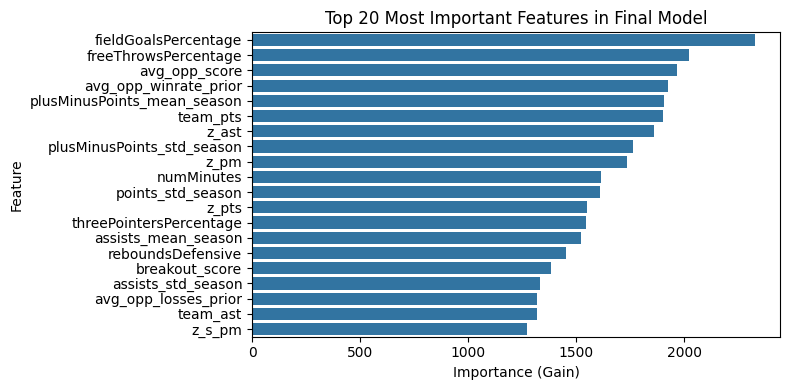

In [47]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': X_all.columns.tolist(),
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
top_20 = importance_df.head(20)

sns.barplot(
    data=top_20,
    y='feature',
    x='importance',
)

plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features in Final Model')
plt.tight_layout()

Looking at our final model's top features, we see that team is the biggest indicator. This is attributed to the fact that there is only 1 winner per conference per week. As such, the best player from each team is most likely the best candidate to win player of the week. If a player is not the best performing player on their team, they are most likely not the winner. Furthermore, we see both individual and team-based features. 'z-ast', 'z-pm', 'z-pts' are the normalized assists, points, and plus minus of a player for that week compared to their rolling average leading up to the current week. 'team_pts' and 'avg_opp_score' are both based on the player's team peformance as well as the player's opponent performance.

### Testing Inference

We will now move on to testing our model on data from the current season: 2025-26. We will test our model for each week so far during this season.

In [48]:
# Reminder: total_inf is our inference set containing data from the 2025-26 season

# Select the same features our model was trained on
X_inf = total_inf.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba'])

# True results
y_inf = total_inf['won_player_of_the_week']

# Set our categorical data
for c in cat_cols:
    X_inf[c] = X_inf[c].astype('category')

# Double check our data does not contain null values
has_null_rows = X_inf.isnull().any(axis=1)
num_rows_with_nulls = has_null_rows.sum()
print(f"Number of rows with null values: {num_rows_with_nulls}")

results = []
k = [1, 3, 5, 10]
k_dict = {i: [] for i in k}

# Group by week, conference (season = 2025)
for (week, conference), group in X_inf.groupby(['week', 'conference'], observed=True):
    # Get corresponding labels for current group
    y_group = y_inf[group.index]

    # Skip if no winner in this group i.e. data from present week
    if y_group.sum() == 0:
        continue

    # Predict winner
    pred = final_model.predict(group)

    # Create results dataframe
    df = total_inf.loc[group.index, ['full_name', 'team']].copy()
    df['score'] = pred
    df['y_true'] = y_group.values
    
    # Sort by prediction score
    df_sorted = df.sort_values('score', ascending=False).reset_index(drop=True)
    
    # Find actual winner's rank
    winner_idx = df_sorted[df_sorted['y_true'] == 1].index
    if len(winner_idx) > 0:
        winner_rank = winner_idx[0] + 1  # Convert to 1-indexed
        
        # Store results
        result = {
            'week': week,
            'conference': conference,
            'actual_winner': df_sorted[df_sorted['y_true'] == 1]['full_name'].values[0],
            'predicted_winner': df_sorted.iloc[0]['full_name'],
            'winner_rank': winner_rank,
            'top_5': df_sorted.head(5)[['full_name', 'team', 'score', 'y_true']].to_dict('records')
        }
        results.append(result)
        
        # Calculate top-k accuracy
        for i in k:
            top_k = df_sorted.head(i)
            hit = top_k['y_true'].max()
            k_dict[i].append(hit)

# Display results
print(f"\nTotal weeks evaluated: {len(results)}")

Number of rows with null values: 0

Total weeks evaluated: 8


In [ ]:
# Show per-week results
for result in results:
    print(f"\nWeek {result['week']} - {result['conference']}:")
    print(f"Actual: {result['actual_winner']}")
    print(f"Predicted: {result['predicted_winner']}")
    print(f"Top 5 predictions:")
    for i, player in enumerate(result['top_5'], 1):
        print(f"{i}. {player['full_name']} ({player['team']}) - Score: {player['score']:.4f}")

# Overall metrics
print("Overall Inference Performance:")

for i in k:
    accuracy = np.mean(k_dict[i])
    print(f"Top-{i} Accuracy: {accuracy:.4f} ({int(accuracy * len(results))}/{len(results)} weeks)")

ranks = [r['winner_rank'] for r in results]
print(f"\nMean Winner Rank: {np.mean(ranks):.2f}")
print(f"Median Winner Rank: {np.median(ranks):.1f}")
print(f"Best Rank: {min(ranks)}")
print(f"Worst Rank: {max(ranks)}")


Week 45 - East:
Actual: Cade Cunningham
Predicted: Cade Cunningham
Top 5 predictions:
1. Cade Cunningham (Pistons) - Score: 0.7814
2. Jalen Duren (Pistons) - Score: -0.2306
3. Donovan Mitchell (Cavaliers) - Score: -0.6697
4. Karl-Anthony Towns (Knicks) - Score: -3.4243
5. Giannis Antetokounmpo (Bucks) - Score: -4.2439

Week 45 - West:
Actual: Nikola Jokic
Predicted: Nikola Jokic
Top 5 predictions:
1. Nikola Jokic (Nuggets) - Score: 3.1131
2. Shai Gilgeous-Alexander (Thunder) - Score: 2.1535
3. Alperen Sengun (Rockets) - Score: -1.5882
4. Isaiah Hartenstein (Thunder) - Score: -3.2387
5. Devin Booker (Suns) - Score: -3.6836

Week 46 - East:
Actual: Jalen Johnson
Predicted: Jalen Johnson
Top 5 predictions:
1. Jalen Johnson (Hawks) - Score: 1.3444
2. Franz Wagner (Magic) - Score: -2.7030
3. Onyeka Okongwu (Hawks) - Score: -3.3803
4. Giannis Antetokounmpo (Bucks) - Score: -4.7085
5. Scottie Barnes (Raptors) - Score: -4.8091

Week 46 - West:
Actual: Nikola Jokic
Predicted: Nikola Jokic
Top 

Our Light GBM lambdarank model achieved 100% top-1 accuracy (8/8 correct predictions) when tested on the 2025-26 season, perfectly predicting every player of the week winner across both conferences. This exceptional performance significantly exceeded our cross-validation, optuna baseline of 61% accuracy from historical data (2001-2024 seasons).

However, important caveats to note are:
1. Small sample size - only 8 weeks of data makes this a preliminary result. We should expect accuracy to stablize closer to ~60% as more weeks are evaluated.
2. Potential for "obvious" winners - These particular weeks may have featured dominant performances that were easy to predict. For example, Nikola Jokic had a score of 2.81 and 4.02. In cases where the race for the award is tight or a player wins it for the first, our model might not predict accurately.
3. Evolution of NBA performance standards - As seen in our cross-validation results, accuracy fluctuated across different validation seasons. The criteria for player of the week selection evolves as the NBA changes: new generations of players enter the league, playing styles shift, and statistical benchmarks increase over time. Since the award is determined by voting that reflects current expectations, our historical normalization features (such as 'z_s_pts', which compares a player's points to past seasons' league-wide averages) may not fully capture how impressive a performance is relative to contemporary standards. A 30-point game that would have been exceptional in 2005 might be less remarkable in 2025's higher-scoring environment.

While 100% accuracy is outstanding, our final model's true performance will be validated as we accumulate predictions over 20-30+ weeks throughout the season. 

### Why Light GBM?

Light GBM is an ideal choice for predicting NBA Player of the Week because it directly addresses the core challenge: ranking players against each other within the same week. Its built-in lambdarank objective is specifically designed for ranking tasks, learning to order players correctly rather than simply classifying winners versus non-winners. The algorithm excels with our large tabular dataset (ours was 100,000+ rows) containing mixed feature types (numerical stats like points and assists, categorical features like team and conference), handling severe class imbalance naturally through its ranking framework. Light GBM is also computationally efficient, enabling rapid hyperparameter tuning, in our case Optuna, and providing interpretable feature importance scores that reveal which statistics (scoring, team success, efficiency) drive player of the week selection. These advantages, ranking optimization, robust handling of mixed data types, speed, and interpretability, make Light GBM a great choice for sports prediction and learning-to-rank problems.

### Ensemble Approach

Let us try an ensemble approach where we alternate our random seed for our models and average out the results. By doing so, each model has:
1. Different data sampling, 'bagging_fraction' randomly samples different rows per tree
2. Different feature sampling, 'feature_fraction' randomly samples different features per tree
3. Different tree structures, small random variations in how each tree is built

This results in each model learning slightly different patterns and makes different mistakes. By averaging our results, our random errors can cancel out.

We also start tracking our feature importance across models.

In [ ]:
# Perform cross validation on all of X
folds = 5
k = [1, 3, 5, 10]
ensemble_seeds = [42, 76, 120, 524, 1023]  # Train 5 models per fold
unique_seasons = sorted(X['season'].unique())

cv_results = []
all_models = []  # Track all models for feature importance
feature_importance_list = []  # Track feature importance per model

# Iterate through each fold, using fold number as key for validation season
for fold in range(1, folds + 1):
    val_season = unique_seasons[-fold]
    train_seasons = unique_seasons[:-fold]
    
    val_mask = X['season'] == val_season
    train_mask = X['season'].isin(train_seasons)

    X_val, y_val = X[val_mask], y[val_mask]
    X_train, y_train = X[train_mask], y[train_mask]

    # Obtain group sizes/starting index by group key
    X_train = X_train.sort_values(by='key')
    y_train = y_train.loc[X_train.index]

    X_val = X_val.sort_values(by='key')
    y_val = y_val.loc[X_val.index]

    tr_group_sizes = X_train.groupby('key').size().to_numpy()
    val_group_sizes = X_val.groupby('key').size().to_numpy()

    # Drop key feature before training and validation
    X_train_features = X_train.drop(columns=['key'])
    X_val_features = X_val.drop(columns=['key'])

    print(f"Validation {fold}")
    print(f"Val. Season: {val_season}")
    print(f"Train Seasons: {train_seasons[0]}-{train_seasons[-1]}")
    print(f"Val. Proportion: {len(y_val) / (len(y_val) + len(X_train)):.4f}")

    # Ensemble: Train multiple models with different seeds
    fold_predictions = []
    fold_models = []
    
    for seed_idx, seed in enumerate(ensemble_seeds):
        print(f"Training model {seed_idx + 1}/{len(ensemble_seeds)} (seed={seed})...")
        
        # Update random seed for this model
        current_params = rank_params.copy()
        current_params['random_state'] = seed
        
        model = lgb.LGBMRanker(**current_params)

        model.fit(
            X_train_features,
            y_train,
            group=tr_group_sizes,
            eval_set=[(X_val_features, y_val)],
            eval_group=[val_group_sizes],
            eval_at=[1, 3, 5, 10],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
            categorical_feature=cat_cols,
        )
        
        pred = model.predict(X_val_features)
        fold_predictions.append(pred)
        fold_models.append(model)
        
        # Track feature importance
        importance = model.feature_importances_
        feature_names = X_train_features.columns.tolist()
        feature_importance_list.append({
            'fold': fold,
            'model_idx': seed_idx,
            'seed': seed,
            'importance': importance,
            'feature_names': feature_names
        })
    
    all_models.append(fold_models)
    
    # Ensemble: Average predictions from all models
    ensemble_pred = np.mean(fold_predictions, axis=0)
    # NEW: Calculate individual model accuracies for comparison
    individual_accuracies = []
    for seed_idx, pred in enumerate(fold_predictions):
        df_temp = X_val[['season', 'week', 'conference']].copy()
        df_temp['y_true'] = y_val.values
        df_temp['score'] = pred
        
        temp_hits = []
        groups_temp = df_temp.groupby(['season', 'week', 'conference'], observed=True)
        for _, group in groups_temp:
            group_sorted = group.sort_values('score', ascending=False).reset_index(drop=True)
            pos_idx = group_sorted.index[group_sorted['y_true'] == 1]
            if len(pos_idx) > 0:
                top_1_hit = 1 if pos_idx[0] == 0 else 0  # Top-1 accuracy
                temp_hits.append(top_1_hit)
        
        individual_acc = np.mean(temp_hits)
        individual_accuracies.append(individual_acc)
        print(f"  Model {seed_idx + 1} (seed={ensemble_seeds[seed_idx]}) Top-1: {individual_acc:.4f}")

    print(f"  Average individual Top-1: {np.mean(individual_accuracies):.4f}")
    # END NEW CODE
    # Evaluate ensemble predictions
    df = X_val[['season', 'week', 'conference']].copy()
    df['y_true'] = y_val.values
    df['score'] = ensemble_pred

    # Stores k-accuracy
    k_dict = {i: [] for i in k}
    
    # Group data rows by season, week, conference
    groups = df.groupby(['season', 'week', 'conference'], observed=True)
    ranks = []
    for _, group in groups:
        group_sorted = group.sort_values('score', ascending=False).reset_index(drop=True)
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1]
        for i in k:
            top_k = group_sorted.head(i)
            hit = top_k['y_true'].max()
            k_dict[i].append(hit)
        for idx in pos_idx:
            ranks.append(idx + 1)
    
    ranks = np.array(ranks)

    ranks = np.array(ranks)
    curr = {"Fold": fold, "Top_rank": ranks.min(), "Lowest_rank": ranks.max(), 
            "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])
    }
    for i, hits in k_dict.items():
        curr[f"Top_{i}_avg_hits"] = np.mean(hits)
    cv_results.append(curr)

Validation 1
Val. Season: 2024
Train Seasons: 2001-2023
Val. Proportion: 0.0459
Training model 1/5 (seed=42)...
Training model 2/5 (seed=76)...
Training model 3/5 (seed=120)...
Training model 4/5 (seed=524)...
Training model 5/5 (seed=1023)...
  Model 1 (seed=42) Top-1: 0.5000
  Model 2 (seed=76) Top-1: 0.5500
  Model 3 (seed=120) Top-1: 0.5250
  Model 4 (seed=524) Top-1: 0.5250
  Model 5 (seed=1023) Top-1: 0.5000
  Average individual Top-1: 0.5200
Validation 2
Val. Season: 2023
Train Seasons: 2001-2022
Val. Proportion: 0.0430
Training model 1/5 (seed=42)...
Training model 2/5 (seed=76)...
Training model 3/5 (seed=120)...
Training model 4/5 (seed=524)...
Training model 5/5 (seed=1023)...
  Model 1 (seed=42) Top-1: 0.5143
  Model 2 (seed=76) Top-1: 0.5143
  Model 3 (seed=120) Top-1: 0.5429
  Model 4 (seed=524) Top-1: 0.5429
  Model 5 (seed=1023) Top-1: 0.5143
  Average individual Top-1: 0.5257
Validation 3
Val. Season: 2022
Train Seasons: 2001-2021
Val. Proportion: 0.0513
Training model

In [ ]:
ensemble_k_df = pd.DataFrame(cv_results)
ensemble_k_df

,Fold,Top_rank,Lowest_rank,Percentiles,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits
0,1,1,18,"[1.0, 1.0, 2.0, 3.5, 5.800000000000004]",0.452381,0.738095,0.880952,0.952381
1,2,1,18,"[1.0, 1.0, 2.0, 3.0, 5.399999999999999]",0.447368,0.763158,0.868421,0.894737
2,3,1,17,"[1.0, 1.0, 2.0, 2.5, 4.0]",0.477273,0.772727,0.909091,0.954545
3,4,1,7,"[1.0, 1.0, 1.0, 2.0, 4.0]",0.568182,0.818182,0.909091,0.931818
4,5,1,8,"[1.0, 1.0, 1.0, 2.75, 4.0]",0.611111,0.805556,0.888889,0.944444


In [ ]:
print(f"Across folds:\nAverage Top-1 Hits: {ensemble_k_df['Top_1_avg_hits'].mean()}\nAverage Top-3 Hits: {ensemble_k_df['Top_3_avg_hits'].mean()}\nAverage Top-5 Hits: {ensemble_k_df['Top_5_avg_hits'].mean()}\nAverage Top-10 Hits: {ensemble_k_df['Top_10_avg_hits'].mean()}")

Across folds:
Average Top-1 Hits: 0.5112630059998481
Average Top-3 Hits: 0.7795435558593453
Average Top-5 Hits: 0.8912888281309334
Average Top-10 Hits: 0.9355851750588592



Top 20 Most Important Features:
               feature  importance_mean  importance_std
              team_pts            93.68       49.370210
                points            91.16       46.682485
                  team            85.40       54.544661
        wins_this_week            76.20       41.455518
               z_s_pts            56.44       29.705326
  fieldGoalsPercentage            56.32       34.088966
        fieldGoalsMade            51.92       29.492942
     reboundsDefensive            49.32       29.584753
              team_ast            40.76       23.107194
                z_s_pm            36.60       17.202325
               assists            33.16       20.747395
               z_s_ast            32.88       20.842879
            numMinutes            32.08       22.038004
games_played_this_week            31.28       17.117290
        breakout_score            28.64       20.188868
         reboundsTotal            28.04       17.291570
   assists_mean

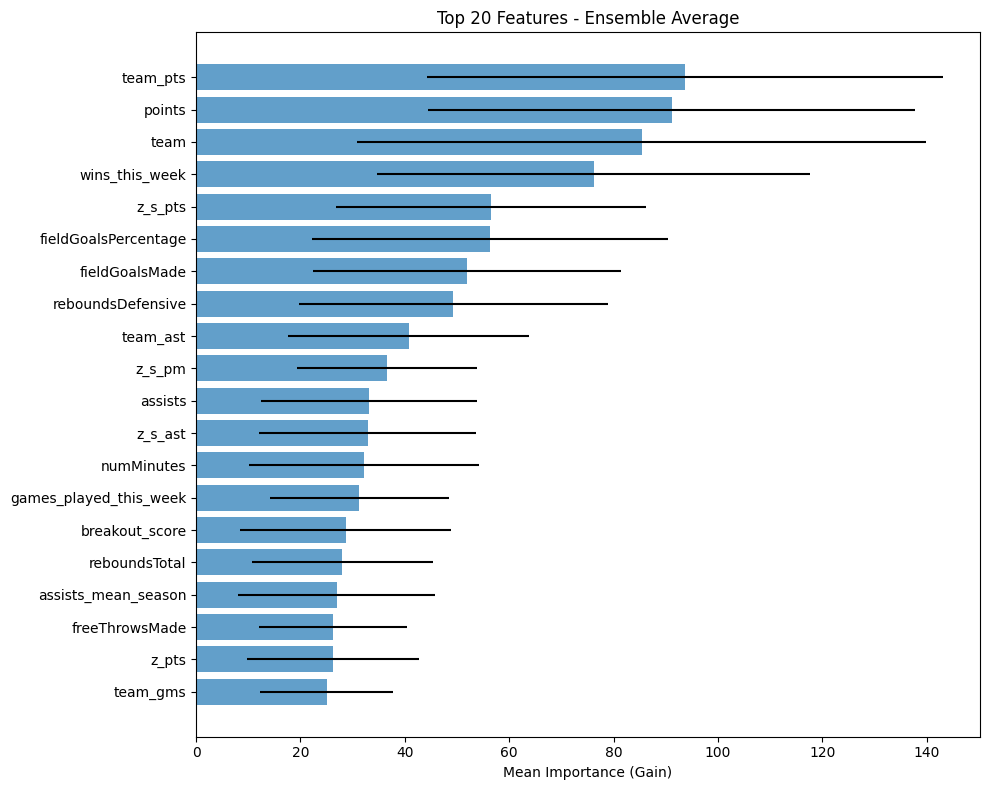


13 features in bottom 20th percentile (threshold: 6.3520):
['conference', 'season', 'threePointersMade', 'league_pts_mean', 'league_ast_std', 'league_pm_mean', 'home_losses_prior', 'home_games_prior', 'league_pts_std', 'away_games_prior', 'away_losses_prior', 'away_win_streak_prior', 'home_win_streak_prior']


In [ ]:
# Aggregate importance across all models
all_importance = []
feature_names = feature_importance_list[0]['feature_names']

for item in feature_importance_list:
    all_importance.append(item['importance'])

all_importance = np.array(all_importance)
mean_importance = all_importance.mean(axis=0)
std_importance = all_importance.std(axis=0)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': mean_importance,
    'importance_std': std_importance,
}).sort_values('importance_mean', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

print("\nBottom 20 Least Important Features:")
print(importance_df.tail(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance_mean'], 
         xerr=top_features['importance_std'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Mean Importance (Gain)')
plt.title('Top 20 Features - Ensemble Average')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Calculate threshold for low importance features
threshold_20 = importance_df['importance_mean'].quantile(0.20)
low_importance_features = importance_df[importance_df['importance_mean'] < threshold_20]['feature'].tolist()

print(f"\n{len(low_importance_features)} features in bottom 20th percentile (threshold: {threshold_20:.4f}):")
print(low_importance_features)

We will then do a clean time-based split our data by season, where our test set will be season 2024-25 and out training set will be seasons before that. This will prevent our groupings being split when distributing our data to training, test, or validation set. If we had split randomly, some groups in the test or validation sets could be missing their corresponding weekly winner (in the training data), resulting in the prediction for that group being invalid. Furthermore, for groups that have their corresponding weekly winner data row in the test or validation set could end up being an "easily predicted" group as some of the players data from that group/week was contained in the training data, which the model trained on. This introduces unwanted bias.

Furthermore, winners are distributed on weekly basis. If we trained our model without grouping, our data isn't independently identically distributed. Our winners are based on their performance compared to historical performances, but it is also based on the performances of other players for that given week in their conference.

*We previously trained our models without grouping our weeks which resulted in near perfect accuracy due to the data leakage. We are adjusting our framework as outlined above to correct this mistake.